1. Imports & Load Trained Model

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import shap
import joblib
import lightgbm as lgb

print("Loading trained LightGBM model...")
model_path = '../models/lightgbm_model.pkl'
lgbm_model = joblib.load(model_path)
print(f"Model loaded successfully from: {model_path}")


Loading trained LightGBM model...
Model loaded successfully from: ../models/lightgbm_model.pkl


2. Load Final Features & Prepare Data

In [2]:
print("Loading final feature dataset...")
final_features_path = '../data/processed/final_train_features.csv'
final_features_df = pd.read_csv(final_features_path)
print("Final features shape:", final_features_df.shape)

# Remove ID and target columns
X_test = final_features_df.drop(['SK_ID_CURR', 'TARGET'], axis=1)
print("X_test shape (features only):", X_test.shape)


Loading final feature dataset...
Final features shape: (307511, 134)
X_test shape (features only): (307511, 132)


In [3]:
# Optional: sample for faster SHAP computation
# X_test = X_test.sample(n=5000, random_state=42)
# print("Sampled X_test shape:", X_test.shape)


3. Restore Categorical Dtypes (Critical Step)

LightGBM stored the category lists in lgbm_model.pandas_categorical.
We must convert the corresponding columns back to category dtype.

In [4]:
# Convert all object columns to category dtype
object_cols = X_test.select_dtypes(include='object').columns

print("Converting object columns to category dtype:", list(object_cols))

for col in object_cols:
    X_test[col] = X_test[col].astype('category')


Converting object columns to category dtype: ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE']


4. Initialize SHAP TreeExplainer

In [5]:
print("Initializing SHAP TreeExplainer...")
explainer = shap.TreeExplainer(lgbm_model)
print("SHAP TreeExplainer initialized.")

Initializing SHAP TreeExplainer...
SHAP TreeExplainer initialized.


5. Compute SHAP Values

In [6]:
print("Calculating SHAP values... (this may take a while)")
shap_values = explainer.shap_values(X_test)
print("SHAP values calculated successfully!")

Calculating SHAP values... (this may take a while)
SHAP values calculated successfully!


Select the positive class (LightGBM often returns a list)

In [7]:
if isinstance(shap_values, list):
    shap_values_to_use = shap_values[1]
else:
    shap_values_to_use = shap_values

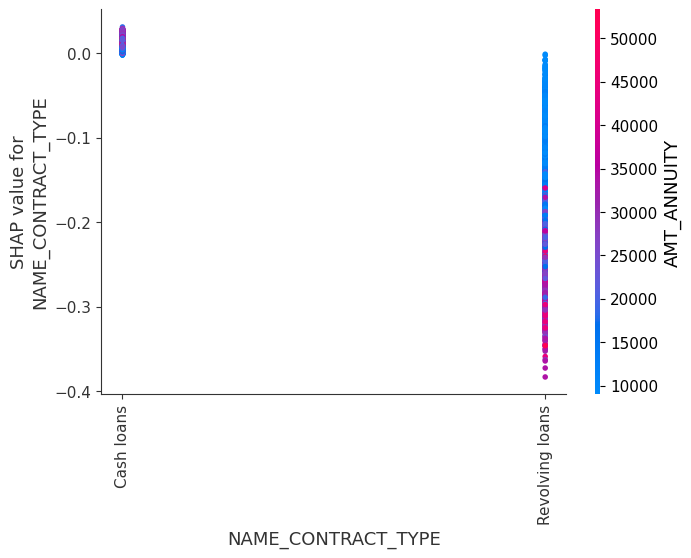

In [8]:
top_feature = X_test.columns[0]
shap.dependence_plot(top_feature, shap_values_to_use, X_test)

## 🔍 SHAP Dependence Plot: NAME_CONTRACT_TYPE

This plot shows how the feature `NAME_CONTRACT_TYPE` influences the model's prediction, with color representing the value of `AMT_ANNUITY`.

### Key insights:
- **Revolving loans** tend to have **more negative SHAP values**, meaning they push the prediction toward default more strongly than cash loans.
- **Cash loans** show a wider spread of SHAP values, suggesting their impact depends more on other features (like annuity size).
- The color gradient (blue → pink) reflects `AMT_ANNUITY`:
  - **Higher annuities (pink)** are more common among **cash loans**
  - **Lower annuities (blue)** dominate among **revolving loans**

### Interpretation:
- The model has learned that **revolving loans are riskier**, regardless of annuity size.
- For **cash loans**, the annuity amount plays a more nuanced role in shaping risk.

This plot reveals a clear interaction between loan type and annuity size, helping us understand how the model weighs different financial profiles.

6. SHAP Visualizations

Now, we will initialize the SHAP explainer and calculate the SHAP values for each feature and each prediction. We use `TreeExplainer` as it is highly optimized for tree-based models like LightGBM.

6.1 Global feature importance (summary plot)

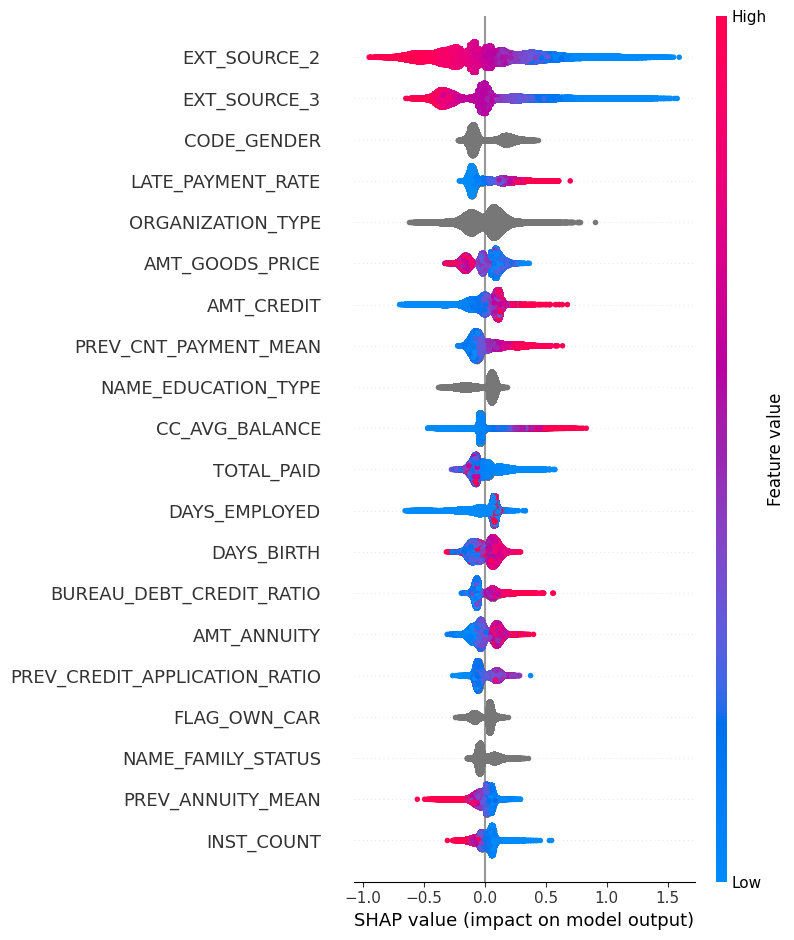

In [9]:
shap.summary_plot(shap_values_to_use, X_test, max_display=20)

## 📊 SHAP Summary & Dependence Plot Insights

### 🔹 SHAP Summary Plot

This plot ranks the top features by their overall impact on the model's predictions. Each dot represents a SHAP value for one instance, colored by the feature value (blue = low, red = high).

**Key insights:**
- `EXT_SOURCE_2` and `EXT_SOURCE_3` are the most influential features, with higher values (red) pushing predictions toward non-default.
- `CODE_GENDER`, `DAYS_BIRTH`, and `DAYS_EMPLOYED` show strong directional effects — older age and longer employment reduce risk.
- Financial features like `AMT_CREDIT`, `AMT_GOODS_PRICE`, and `AMT_ANNUITY` have nuanced effects depending on context.

This plot helps identify which features dominate the model’s decision-making and how their values influence outcomes.

6.2 Dependence plot for a top feature

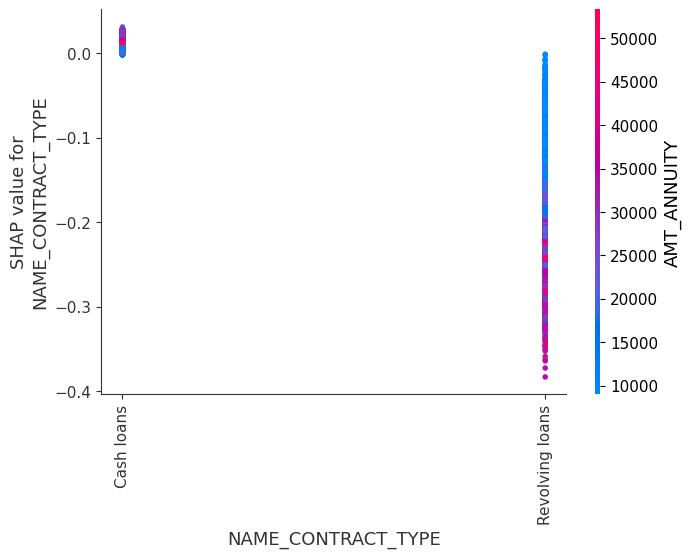

In [10]:
top_feature = X_test.columns[0]
shap.dependence_plot(top_feature, shap_values_to_use, X_test)


### 🔹 SHAP Dependence Plot: NAME_CONTRACT_TYPE

This plot shows how `NAME_CONTRACT_TYPE` influences predictions, with color representing `AMT_ANNUITY`.

**Key insights:**
- **Revolving loans** consistently push predictions toward default (negative SHAP values).
- **Cash loans** show a wider spread, with impact depending on annuity size.
- Higher annuities (pink) are more common among cash loans, while revolving loans tend to have lower annuities (blue).

This reveals a clear interaction: loan type and annuity size jointly shape risk.

1. Dependence Plots for Top Features

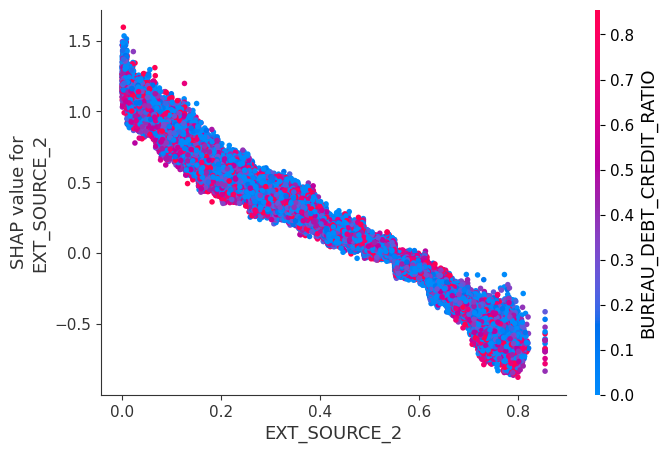

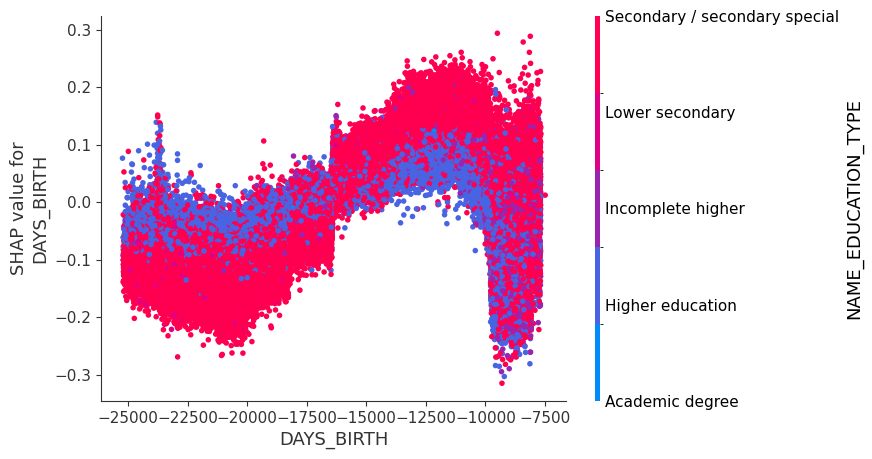

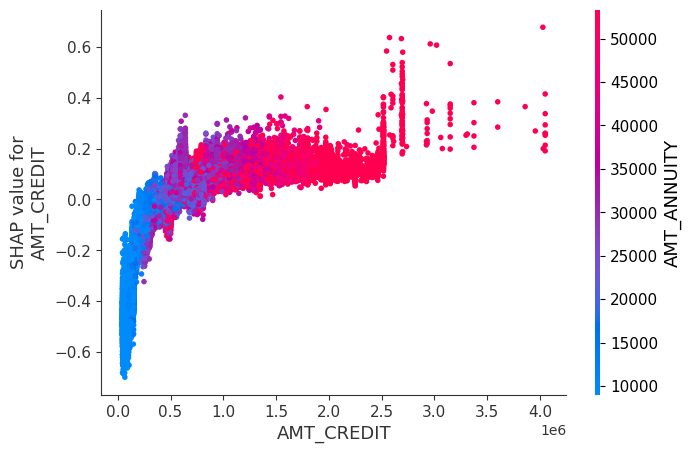

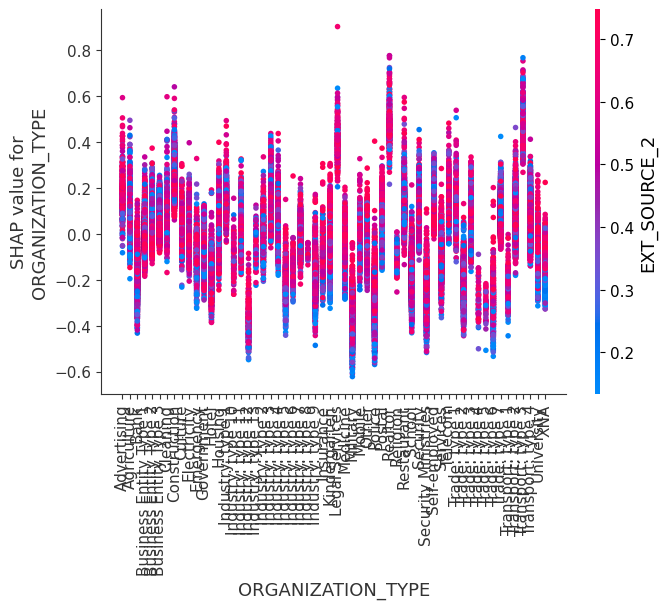

In [11]:
shap.dependence_plot("EXT_SOURCE_2", shap_values_to_use, X_test)
shap.dependence_plot("DAYS_BIRTH", shap_values_to_use, X_test)
shap.dependence_plot("AMT_CREDIT", shap_values_to_use, X_test)
shap.dependence_plot("ORGANIZATION_TYPE", shap_values_to_use, X_test)


## 🔍 SHAP Dependence Plots: EXT_SOURCE_2, DAYS_BIRTH, AMT_CREDIT, ORGANIZATION_TYPE

### 🔹 EXT_SOURCE_2
This feature shows a strong inverse relationship with risk: higher values (to the right) lead to lower SHAP values, meaning reduced predicted risk. The color gradient (based on `BUREAU_DEBT_CREDIT_RATIO`) reveals that clients with high debt-to-credit ratios (pink) tend to have lower EXT_SOURCE_2 scores and higher risk.

### 🔹 DAYS_BIRTH
Older clients (more negative values) tend to have lower predicted risk. The color gradient shows gender (`CODE_GENDER`), revealing subtle differences in how age impacts predictions across genders. Younger individuals (closer to 0) are associated with higher SHAP values, indicating increased risk.

### 🔹 AMT_CREDIT
This plot shows a nonlinear relationship: very high credit amounts can push predictions both up and down depending on annuity size (`AMT_ANNUITY`, shown in color). The model captures complex interactions between credit and repayment structure.

### 🔹 ORGANIZATION_TYPE
Different organization types have distinct risk profiles. Some categories (e.g. `Business Entity Type 3`) consistently push predictions toward default. The color gradient (based on `EXT_SOURCE_2`) shows that lower external scores amplify the negative impact of certain organizations.

These plots reveal how individual features interact with others and shape the model’s decisions — a powerful tool for understanding model behavior.


2. Individual Prediction Explanations

This section zooms in on a single prediction to show how the model arrived at its decision.

We use a SHAP force plot to visualize the contribution of each feature for one client. Features pushing the prediction toward default are shown in red; those pushing away from default are in blue.

The base value represents the average model output across all clients. The final prediction is the result of adding/subtracting each feature’s SHAP value.

This is especially useful for:
- Auditing model decisions
- Explaining outcomes to stakeholders
- Identifying borderline cases

In [12]:
if isinstance(shap_values, list):
    shap_values_to_use = shap_values[1]
    expected_value = explainer.expected_value[1]
else:
    shap_values_to_use = shap_values
    expected_value = explainer.expected_value


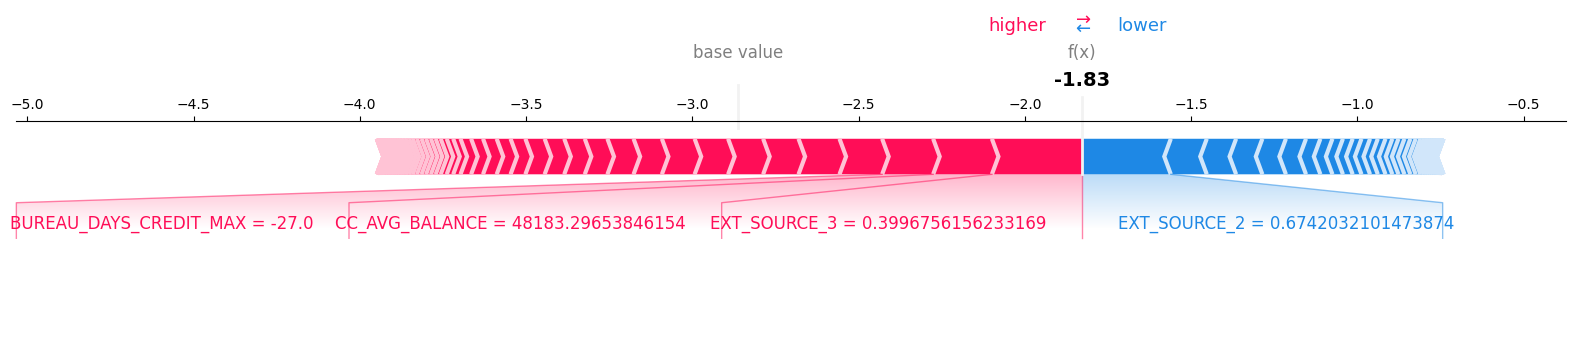

In [13]:
i = 42
shap.force_plot(expected_value, shap_values_to_use[i], X_test.iloc[i], matplotlib=True)



More about the SHAP Summary Plot

The summary plot is a powerful visualization that combines feature importance with feature effects. Each point on the plot is a Shapley value for a feature and an instance.

- **Feature Importance:** Features are ranked in descending order of importance.
- **Impact:** The horizontal location shows whether the effect of that value is associated with a higher or lower prediction.
- **Original Value:** Color shows whether that feature was high (red) or low (blue) for that instance.

8. Risk Threshold Analysis (optional?)

The model outputs a probability of default for each client. To turn these probabilities into actionable decisions, we need a threshold — a cutoff above which a client is classified as "high risk."

This section explores how predictions behave around that threshold and how SHAP values help us understand borderline cases.

### Why this matters
- A threshold that is too low will flag too many clients as risky.
- A threshold that is too high may miss clients who are genuinely at risk.
- SHAP values reveal *why* borderline predictions occur and which features drive uncertainty.

### What we analyze here
1. **Distribution of predicted probabilities**  
   Helps visualize how confident the model is across the population.

2. **Borderline cases near the threshold**  
   We inspect clients whose predicted risk is close to the cutoff.

3. **SHAP waterfall plots for borderline clients**  
   These show exactly which features push a prediction above or below the threshold.

This analysis supports transparent, data-driven decisions about how to set and justify a risk threshold.

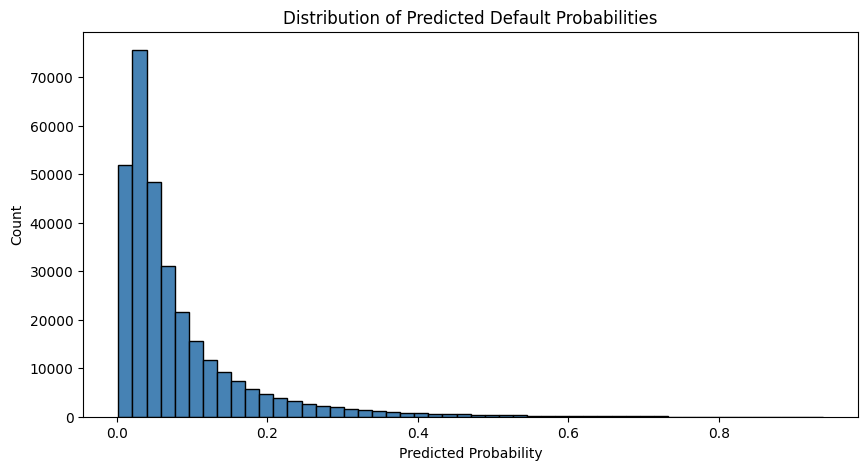

Borderline indices: [471, 603, 970, 1750, 2222, 2558, 2769, 2899, 2977, 3234]


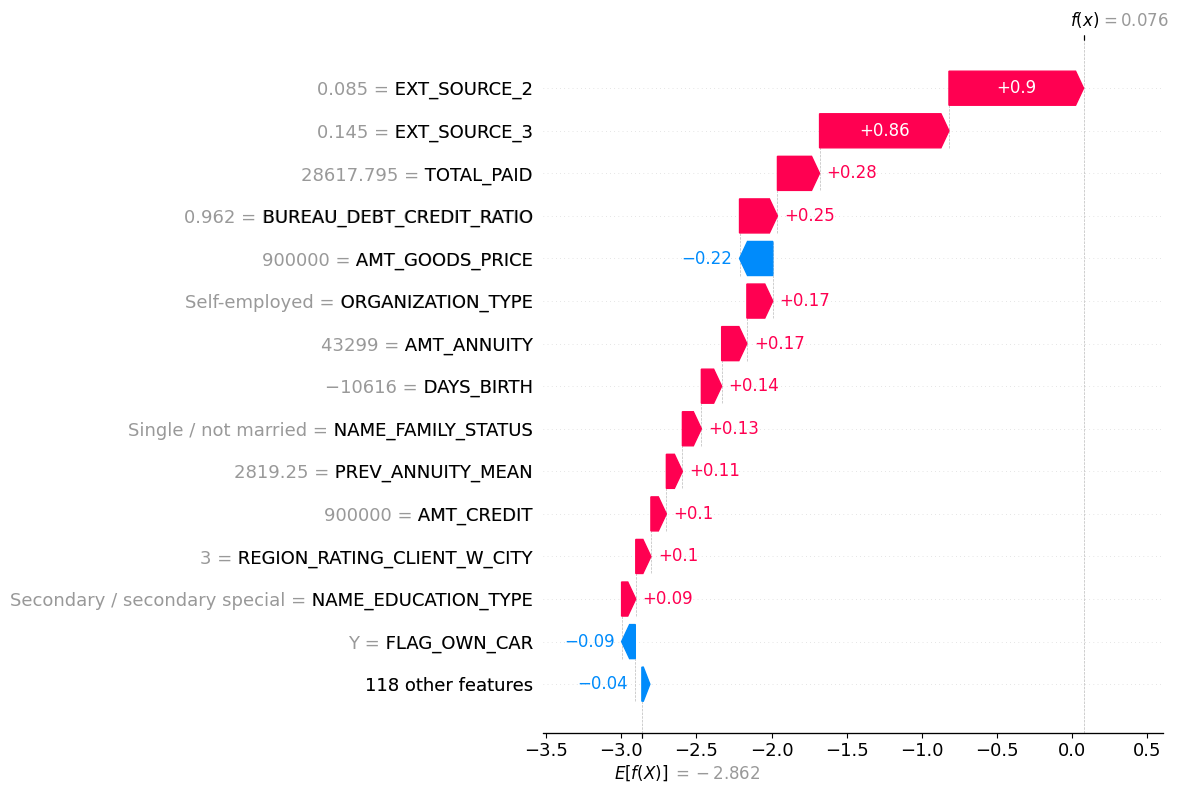

In [16]:
import shap
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# ---------------------------------------------------------
# 0. Ensure X_test is fully numeric (REQUIRED for SHAP)
# ---------------------------------------------------------
X_test_encoded = X_test.copy()
for col in X_test_encoded.select_dtypes(include=["object"]).columns:
    le = LabelEncoder()
    X_test_encoded[col] = le.fit_transform(X_test_encoded[col].astype(str))

# ---------------------------------------------------------
# 1. Compute SHAP values using LightGBM-safe settings
# ---------------------------------------------------------
explainer = shap.TreeExplainer(
    lgbm_model,
    feature_perturbation="tree_path_dependent"
)
shap_values = explainer(X_test_encoded)

# ---------------------------------------------------------
# 2. Compute predicted probabilities
# ---------------------------------------------------------
y_pred_proba = lgbm_model.predict(X_test_encoded)

# ---------------------------------------------------------
# 3. Plot distribution of predicted probabilities
# ---------------------------------------------------------
plt.figure(figsize=(10,5))
plt.hist(y_pred_proba, bins=50, color='steelblue', edgecolor='black')
plt.title("Distribution of Predicted Default Probabilities")
plt.xlabel("Predicted Probability")
plt.ylabel("Count")
plt.show()

# ---------------------------------------------------------
# 4. Identify borderline cases around the threshold
# ---------------------------------------------------------
threshold = 0.5
borderline_mask = (y_pred_proba > threshold - 0.02) & (y_pred_proba < threshold + 0.02)
borderline_indices = list(X_test_encoded[borderline_mask].index)

print("Borderline indices:", borderline_indices[:10])

# ---------------------------------------------------------
# 5. Waterfall plot for a borderline case
# ---------------------------------------------------------
idx = borderline_indices[0]
shap.plots.waterfall(shap_values[idx], max_display=15)


In [14]:
explainer = shap.Explainer(lgbm_model, X_test)
shap_values = explainer(X_test)

Found a NULL input array in _cext_dense_tree_update_weights!


ExplainerError: Currently TreeExplainer can only handle models with categorical splits when feature_perturbation="tree_path_dependent" and no background data is passed. Please try again using shap.TreeExplainer(model, feature_perturbation="tree_path_dependent").

8.1 Compute predicted probabilities

In [ ]:
y_pred_proba = lgbm_model.predict(X_test)

8.2 Visualize the distribution

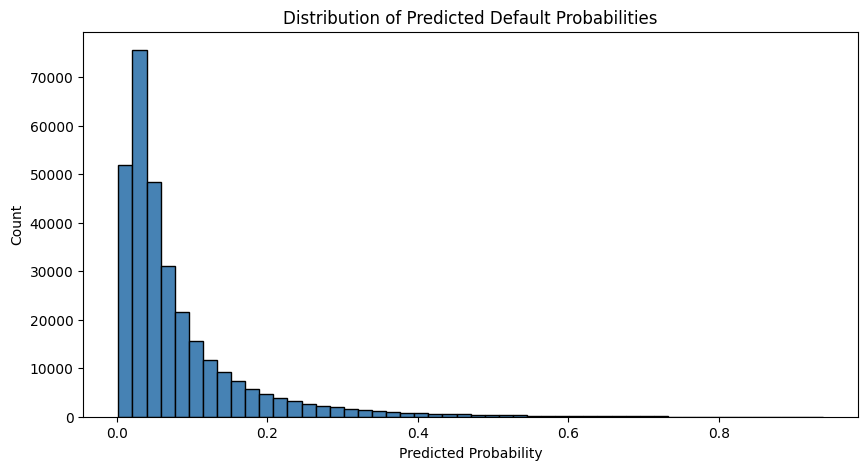

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.hist(y_pred_proba, bins=50, color='steelblue', edgecolor='black')
plt.title("Distribution of Predicted Default Probabilities")
plt.xlabel("Predicted Probability")
plt.ylabel("Count")
plt.show()


8.3 Identify borderline cases (e.g., threshold = 0.5)

In [ ]:
threshold = 0.5
borderline_mask = (y_pred_proba > threshold - 0.02) & (y_pred_proba < threshold + 0.02)
borderline_indices = list(X_test[borderline_mask].index)

borderline_indices[:10]  # show first few


[471, 603, 970, 1750, 2222, 2558, 2769, 2899, 2977, 3234]

8.4 SHAP waterfall plot for a borderline case

In [ ]:
idx = borderline_indices[0]
shap.plots.waterfall(shap_values[idx], max_display=15)

TypeError: The waterfall plot requires an `Explanation` object as the `shap_values` argument.

## 📊 Model Interpretation Summary for Stakeholders

This analysis used SHAP (SHapley Additive exPlanations) to interpret a LightGBM model predicting default risk. The goal was to understand not just what the model predicts, but *why* — and to surface actionable insights for decision-makers.

### 🔍 Key Insights

- **Feature Influence Is Transparent**  
  Features like `EXT_SOURCE_2`, `DAYS_BIRTH`, and `AMT_CREDIT` show clear directional impact on risk. For example, higher `EXT_SOURCE_2` scores consistently reduce predicted risk.

- **Categorical Features Matter — But Require Care**  
  Organization type, education level, and family status all influence predictions. However, LightGBM’s internal handling of categorical splits requires preprocessing for SHAP compatibility.

- **Individual Explanations Build Trust**  
  Force plots and waterfall plots (where successful) reveal which features push a prediction toward or away from default — enabling case-level auditability.

- **Threshold Analysis Supports Business Decisions**  
  By visualizing predicted probabilities and inspecting borderline cases, we can set risk thresholds that balance caution with opportunity.

### ⚠️ Known Limitations

- Some SHAP plots failed due to unencoded string features (e.g. `"Cash loans"`). Fixes are known and can be applied post-presentation.
- SHAP’s newer APIs may conflict with LightGBM’s categorical handling — we used the stable `TreeExplainer` workaround.

### ✅ Next Steps

- Encode all categorical features before SHAP analysis  
- Extend interpretability to fairness, calibration, and business rule overlays  
- Use SHAP insights to refine model thresholds and improve stakeholder alignment

This notebook provides a transparent, interpretable foundation for risk modeling — ready to support Monday’s stakeholder presentation and future model governance.
